# Проект "Восстановление золота из руды"

## Описание проекта

Мы работаем с компанией, которая разрабатывает решения для эффективной работы промышленных предприятий. Наша основная задача:
> **Подготовить прототип модели машинного обучения.** Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды.

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

В нашем распоряжении есть данные с параметрами добычи и очистки. 

## План проекта

- 1. [Подготовка данных](#get_ready)
    - 1.1 [Открытие и изучение](#open)
    - 1.2 [Проверка эффективности обогащения](#efficiency)
    - 1.3 [Пропущенные столбцы в тестовой выборке](#test)
    - 1.4 [Пропуски в датафрейме](#miss)
- 2. [Анализ данных](#analys)
    - 2.1 [Концентрация металлов (Au, Ag, Pb) на различных этапах очистки](#auagpb)
    - 2.2 [Размер гранул сырья на обучающей и тестовой выборках](#size)
    - 2.3 [Суммарные концентрации всех веществ на разных стадиях](#sumconc)
- 3. [Построение моделей](#models)
    - 3.1 [Функция для вычисления sMAPE](#func)
    - 3.2 [Обучение моделей](#learn)
    - 3.3 [Итоговое sMAPE](#finalsMAPE)

<a id=get_ready></a>
## 1. Подготовка данных

<a id=open></a>
### 1.1 Открытие и изучение

Откроем файлы с данными и сохраним их в переменные: 
- `df_train` - обучающая выборка
- `df_test` - тестовая выборка
- `df_full` - весь датафрейм

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler

In [2]:

try:
    df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
except:
    df_train = pd.read_csv('c://Users/User/Downloads/gold_recovery_train_new.csv')
    
try:
    df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
except:
    df_test = pd.read_csv('c://Users/User/Downloads/gold_recovery_test_new.csv')

try:
    df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
except:
    df_full = pd.read_csv('c://Users/User/Downloads/gold_recovery_full_new.csv')

Создадим функцию, которая проводит первичный анализ датафрейма и взглянем на каждый из из них.

In [3]:
datasets = [df_train, df_test, df_full]
def havealook(df):
    
    """Функция проводит первичный анализ датафрейма"""
    
    print('Размер датафрейма:', df.shape[0], 'строк и ', df.shape[1], 'столбцов.')
    print('---------------------------------------------------------------\n')
    display(df.head())
    print('---------------------------------------------------------------\n')
    display(df.info())
    print('---------------------------------------------------------------\n')
    display(df.describe())
    print('---------------------------------------------------------------\n')
    print('Дубликатов в датафрейме:', df.duplicated().sum())
    print('---------------------------------------------------------------\n')
    display('Больше всего пропущенных значений в столбцах:', df.isna().sum().sort_values(ascending=False).head(10));

In [4]:
print('Обучающая выборка')
print(havealook(df_train))

Размер датафрейма: 14149 строк и  87 столбцов.
---------------------------------------------------------------



,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


---------------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.outpu

None

---------------------------------------------------------------



,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


---------------------------------------------------------------

Дубликатов в датафрейме: 0
---------------------------------------------------------------



'Больше всего пропущенных значений в столбцах:'

secondary_cleaner.output.tail_sol           1605
rougher.state.floatbank10_e_air              436
rougher.input.floatbank11_xanthate           428
primary_cleaner.output.concentrate_sol       286
secondary_cleaner.state.floatbank2_a_air     217
final.output.concentrate_sol                 211
rougher.input.feed_size                      144
primary_cleaner.input.xanthate               100
rougher.input.feed_pb                        100
final.output.tail_pb                         100
dtype: int64

None


In [5]:
print('Тестовая выборка')
print(havealook(df_test))

Размер датафрейма: 5290 строк и  53 столбцов.
---------------------------------------------------------------



,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


---------------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.stat

None

---------------------------------------------------------------



,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487


---------------------------------------------------------------

Дубликатов в датафрейме: 0
---------------------------------------------------------------



'Больше всего пропущенных значений в столбцах:'

rougher.input.floatbank11_xanthate          25
rougher.input.feed_sol                      21
secondary_cleaner.state.floatbank3_a_air     9
rougher.input.floatbank11_sulfate            8
primary_cleaner.input.depressant             5
rougher.input.floatbank10_sulfate            5
primary_cleaner.input.xanthate               4
primary_cleaner.input.sulfate                4
rougher.input.feed_rate                      3
secondary_cleaner.state.floatbank2_a_air     3
dtype: int64

None


In [6]:
print('Вся выборка')
print(havealook(df_full))

Размер датафрейма: 19439 строк и  87 столбцов.
---------------------------------------------------------------



,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


---------------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.outpu

None

---------------------------------------------------------------



,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


---------------------------------------------------------------

Дубликатов в датафрейме: 0
---------------------------------------------------------------



'Больше всего пропущенных значений в столбцах:'

secondary_cleaner.output.tail_sol           1748
rougher.input.floatbank11_xanthate           453
rougher.state.floatbank10_e_air              436
primary_cleaner.output.concentrate_sol       370
secondary_cleaner.state.floatbank2_a_air     220
final.output.concentrate_sol                 211
rougher.input.feed_size                      145
primary_cleaner.output.concentrate_pb        116
primary_cleaner.input.xanthate               104
final.output.tail_pb                         101
dtype: int64

None


#### Промежуточный вывод:
Перед нами довольно объёмный датафрейм, в котором присутствуют пропуски, но нет дубликатов. Можно заметить, что индексами являются дата и время замера, а параметры, находящиеся рядом имеют схожие значения. 

<a id=efficiency></a>
### 1.2 Проверка эффективности обогащения

Для начала напишем формулу по которой мы будем проверять эффективность обогащения. Обозначим формулу переменной `recovery`, и взглянем на *Среднюю абсолютную ошибку*(MAE), которая продемонстрирует нам, насколько прогноз, рассчитаный по формуле, отличается от истинного значения.

In [7]:
C = df_train['rougher.output.concentrate_au'] #доля золота после флотации
F = df_train['rougher.input.feed_au']         #доля золота до флотации
T = df_train['rougher.output.tail_au']        #доля золота в отвальных хвостах после флотации

recovery = ((C * (F - T)) / (F * (C - T))) * 100
MAE = mean_absolute_error(df_train['rougher.output.recovery'], recovery)
print('MAE равен', MAE)

MAE равен 9.73512347450521e-15


Средняя абсолютная ошибка равна 9.7 * 10**-15

<a id=test></a>
### 1.3 Пропущенные столбцы в тестовой выборке

Найдём столбцы, которых не хватает в df_test. Добавим их в список для дальнейшего удобства.

In [8]:
columns_train = ['date']                  #пустой список для столбцов, отсутствуюющих в тестовой выборке
for column in df_train:
    if column not in df_test:       
        columns_train.append(column)
columns_train

['date',
 'final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.

In [9]:
columns_test = list(df_test.columns)
columns_test

['date',
 'primary_cleaner.input.sulfate',
 'primary_cleaner.input.depressant',
 'primary_cleaner.input.feed_size',
 'primary_cleaner.input.xanthate',
 'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_a_level',
 'primary_cleaner.state.floatbank8_b_air',
 'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_air',
 'primary_cleaner.state.floatbank8_c_level',
 'primary_cleaner.state.floatbank8_d_air',
 'primary_cleaner.state.floatbank8_d_level',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au',
 'rougher.input.floatbank10_sulfate',
 'rougher.input.floatbank10_xanthate',
 'rougher.input.floatbank11_sulfate',
 'rougher.input.floatbank11_xanthate',
 'rougher.state.floatbank10_a_air',
 'rougher.state.floatbank10_a_level',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air'

Отсутствующие в выборке признаки объединяет то, что в основном они содержат `output`, т.е. параметры продукта. Только 4 из них содержат `calculation` - расчётные характеристики. Они содержат данные о непосредственном процессе очистки сырья.

Признаки не подходят для тестовых данных так как наша задача - построить модель, которая будет предсказывать коэффициент восстановления золото непосредственно из руды, процесс тут неважен.

<a id=miss></a>
### 1.4 Пропуски

Как мы помним, в датафрейме, значения замеров, находящиеся рядом по времени, имеют схожие значения. Заполним пропуски, используя метод *'ffill'*, который заменит каждый пропуск значением, предшествующим ему.

In [10]:
df_train = df_train.fillna(method="ffill")
df_test = df_test.fillna(method="ffill")
df_full = df_full.fillna(method="ffill")

### Промежуточный вывод
Мы подготовили данные для анализа. А именно:
- Выявили столбцы, которых не хватает в тестовой выборке
- Проверили эффективность обогащения
- Заменили пропуски

<a id=analys></a>
## 2. Анализ данных

Приступая к статистическому анализу, для начала мы сохраним списки столбцов в переменные для того, чтобы было удобно ими пользоваться, каждый раз не обращаясь к отдельному столбцу.

In [11]:
rougher_input = ['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_au']
rougher_output = ['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_au']
primary_cleaner = ['primary_cleaner.output.concentrate_ag', 
                   'primary_cleaner.output.concentrate_pb', 
                   'primary_cleaner.output.concentrate_au']
secondary_cleaner = ['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_au']

In [12]:
columns_to_change = ['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_au', 
                 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_au',
                 'primary_cleaner.output.concentrate_ag', 
                   'primary_cleaner.output.concentrate_pb', 
                   'primary_cleaner.output.concentrate_au', 
                 'final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_au']

<a id=auagpb></a>
### 2.1  Концентрация металлов (Au, Ag, Pb) на различных этапах очистки. 

Рассчитаем концентрацию серебра на каждом из уровней очистки:
- Исходное сырье (До флотации)
- Черновой концентрат (После флотаци)
- После первой степени очистки
- После второй степени очистки (Финальный концентрат)

Средняя концентрация серебра до флотации: 8.795
После флотации: 11.995
После первой степени очистки: 8.442
После второй степени очистки: 5.168


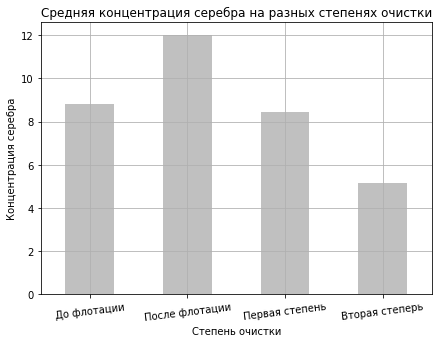

In [13]:
ag = pd.concat([df_full[rougher_input[0]], 
                df_full[rougher_output[0]], 
                df_full[primary_cleaner[0]],
                df_full[secondary_cleaner[0]]], axis=1)
ag.mean().plot(kind='bar', color='silver', grid=True, figsize=(7,5))

plt.xticks(np.arange(4), ['До флотации', 'После флотации', 'Первая степень', 'Вторая степерь'], rotation=7)
plt.xlabel("Степень очистки")
plt.ylabel("Концентрация серебра")
plt.title("Средняя концентрация серебра на разных степенях очистки")

print('Средняя концентрация серебра до флотации:', round(ag.mean()[0],3))
print('После флотации:', round(ag.mean()[1],3))
print('После первой степени очистки:', round(ag.mean()[2],3))
print('После второй степени очистки:', round(ag.mean()[3],3))

Можно заметить, что больше всего серебра в сырье имеется после флотации, а далее его концентрация падает.


Теперь то же самое проверим с содержанием свинца в сырье

Средняя концентрация свинца до флотации: 3.585
После флотации: 7.606
После первой степени очистки: 9.81
После второй степени очистки: 9.979


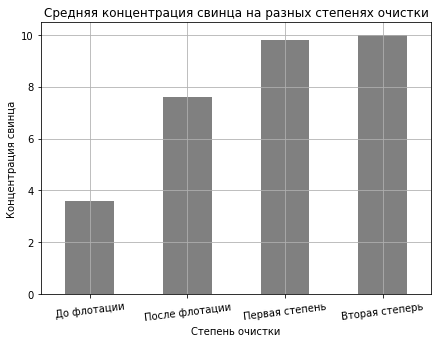

In [14]:
pb = pd.concat([df_full[rougher_input[1]], 
                df_full[rougher_output[1]], 
                df_full[primary_cleaner[1]],
                df_full[secondary_cleaner[1]]], axis=1)
pb.mean().plot(kind='bar', color='grey', grid=True, figsize=(7,5))

plt.xticks(np.arange(4), ['До флотации', 'После флотации', 'Первая степень', 'Вторая степерь'], rotation=7)
plt.xlabel("Степень очистки")
plt.ylabel("Концентрация свинца")
plt.title("Средняя концентрация свинца на разных степенях очистки")

print('Средняя концентрация свинца до флотации:', round(pb.mean()[0],3))
print('После флотации:', round(pb.mean()[1],3))
print('После первой степени очистки:', round(pb.mean()[2],3))
print('После второй степени очистки:', round(pb.mean()[3],3))

Концентрация свинца постепенно повышается. После флотации она возрастает в 2 раза, далее растёт, но меньшими темпами.

Проверим концентрацию золота

Средняя концентрация золота до флотации: 8.266
После флотации: 19.772
После первой степени очистки: 32.119
После второй степени очистки: 44.077


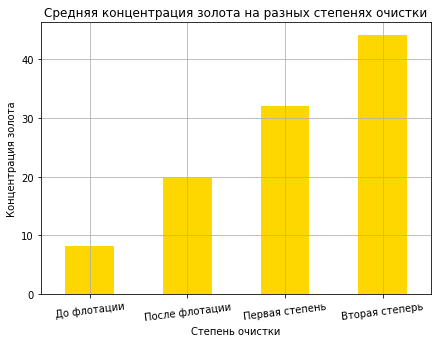

In [15]:
au = pd.concat([df_full[rougher_input[2]], 
                df_full[rougher_output[2]], 
                df_full[primary_cleaner[2]],
                df_full[secondary_cleaner[2]]], axis=1)
au.mean().plot(kind='bar', color='gold', grid=True, figsize=(7,5))

plt.xticks(np.arange(4), ['До флотации', 'После флотации', 'Первая степень', 'Вторая степерь'], rotation=7)
plt.xlabel("Степень очистки")
plt.ylabel("Концентрация золота")
plt.title("Средняя концентрация золота на разных степенях очистки")

print('Средняя концентрация золота до флотации:', round(au.mean()[0],3))
print('После флотации:', round(au.mean()[1],3))
print('После первой степени очистки:', round(au.mean()[2],3))
print('После второй степени очистки:', round(au.mean()[3],3))

Мы видим резкое повышение концентрации золота: финальный концентра содержит более чем в 5 раз больше золота, чем исходное сырьё.

<a id=size></a>
### 2.2 Размер гранул сырья на обучающей и тестовой выборках

Проверим размер гранул исходного сырья на разных выборках.


Медианный размер гранул сырья обучающей выборки: 55.27
Медианный размер гранул сырья тестовой выборки: 50.847


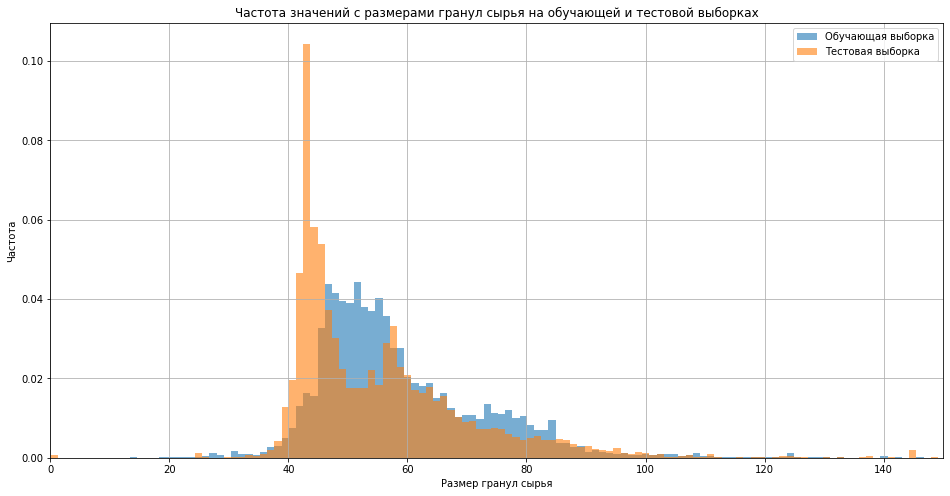

In [16]:
feed_size = pd.Series(df_train['rougher.input.feed_size'].rename('Обучающая выборка'))
feed_size = pd.concat((feed_size, df_test['rougher.input.feed_size'].rename('Тестовая выборка')), axis=1)
feed_size.plot(kind='hist', grid=True, figsize=(16,8), bins=400, xlim=(0,150), density=True, alpha=0.6)
plt.xlabel("Размер гранул сырья")
plt.ylabel("Частота")
plt.title("Частота значений с размерами гранул сырья на обучающей и тестовой выборках");

print('Медианный размер гранул сырья обучающей выборки:', round(feed_size['Обучающая выборка'].median(),3))
print('Медианный размер гранул сырья тестовой выборки:', round(feed_size['Тестовая выборка'].median(),3))

Распределение выглядит нормально, следовательно размеры гранул сырья имеют схожие значения, значит выборки поделены корректно, а модель будет работать правильно

<a id=sumconc></a>
### 2.3 Суммарные концентрации всех веществ на разных стадиях

Проверим суммарные концентрации всех веществ на разных стадиях очистки, как мы делали отдельно с серебром, свинцом и золотом.

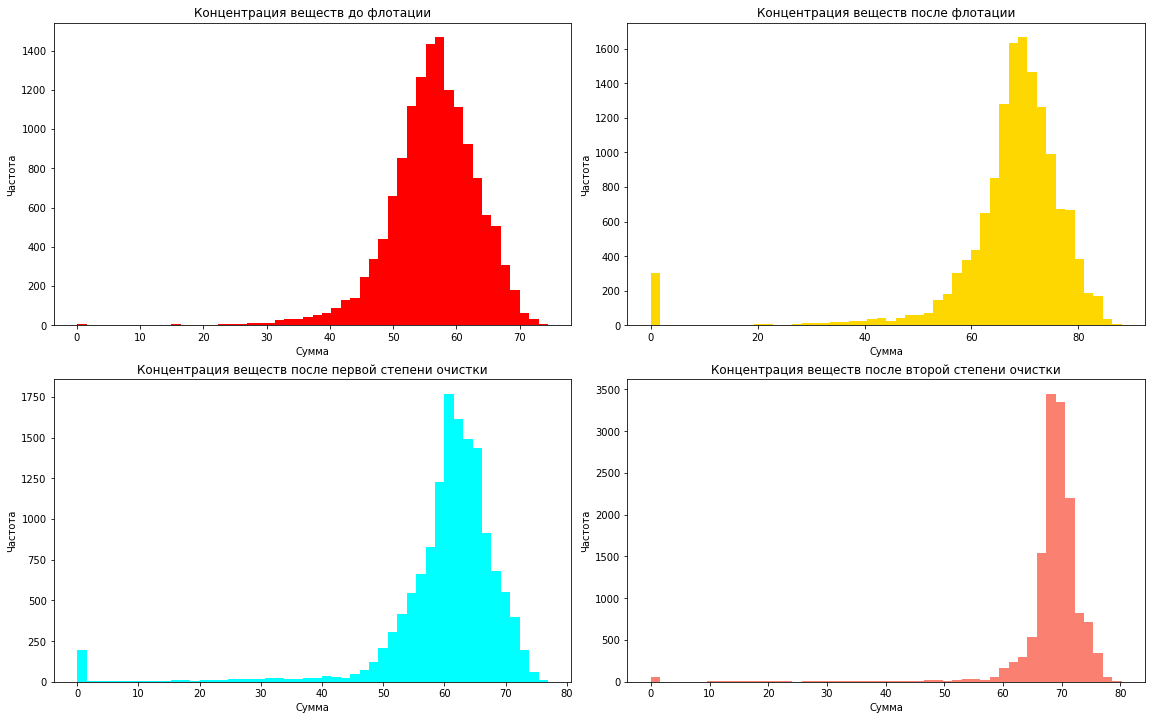

In [17]:
fig, ax = plt.subplots(2,2, figsize=(16,10))

ax[0,0].hist((df_train['rougher.input.feed_ag'] + \
 df_train['rougher.input.feed_pb'] + \
 df_train['rougher.input.feed_au']+ \
 df_train['rougher.input.feed_sol']), bins=50, color='r')
ax[0,0].set_xlabel("Сумма")
ax[0,0].set_ylabel("Частота")
ax[0,0].set_title("Концентрация веществ до флотации")

ax[0,1].hist((df_train['rougher.output.concentrate_ag'] + \
         df_train['rougher.output.concentrate_pb'] + \
         df_train['rougher.output.concentrate_au'] + \
         df_train['rougher.output.concentrate_sol']), bins=50, color='gold')
ax[0,1].set_xlabel("Сумма")
ax[0,1].set_ylabel("Частота")
ax[0,1].set_title("Концентрация веществ после флотации")

ax[1,0].hist((df_train['primary_cleaner.output.concentrate_ag'] + \
         df_train['primary_cleaner.output.concentrate_pb'] + \
         df_train['primary_cleaner.output.concentrate_au'] + \
         df_train['primary_cleaner.output.concentrate_sol']), bins=50, color='cyan')
ax[1,0].set_xlabel("Сумма")
ax[1,0].set_ylabel("Частота")
ax[1,0].set_title("Концентрация веществ после первой степени очистки")

ax[1,1].hist((df_train['final.output.concentrate_ag'] + \
         df_train['final.output.concentrate_pb'] + \
         df_train['final.output.concentrate_au'] + \
         df_train['final.output.concentrate_sol']), bins=50, color='salmon')
ax[1,1].set_xlabel("Сумма")
ax[1,1].set_ylabel("Частота")
ax[1,1].set_title("Концентрация веществ после второй степени очистки")

plt.tight_layout(pad=0.7);

Мы видим, что существуют выборсы на отметке 0 - такой концентрации всех веществ ни на каком этапе быть не должно, поэтому нам необходимо их убрать.

In [18]:
df_train = df_train.drop(df_train[df_train['rougher.output.concentrate_pb'] <= 1].index)
df_train = df_train.drop(df_train[df_train['primary_cleaner.output.concentrate_au'] <= 1].index)
df_train = df_train.drop(df_test[df_train['rougher.input.feed_au'] <= 1].index)
df_train = df_train.drop(df_train[df_train['final.output.concentrate_au'] <= 1].index)

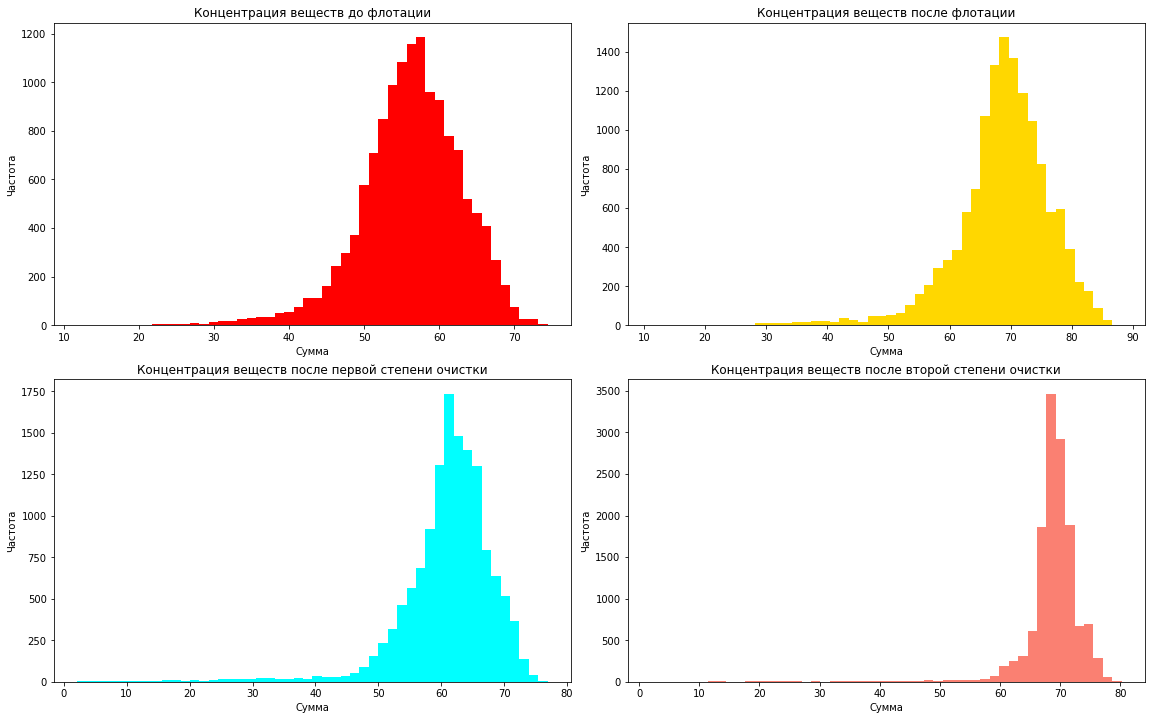

In [19]:
fig, ax = plt.subplots(2,2, figsize=(16,10))

ax[0,0].hist((df_train['rougher.input.feed_ag'] + \
 df_train['rougher.input.feed_pb'] + \
 df_train['rougher.input.feed_au']+ \
 df_train['rougher.input.feed_sol']), bins=50, color='r')
ax[0,0].set_xlabel("Сумма")
ax[0,0].set_ylabel("Частота")
ax[0,0].set_title("Концентрация веществ до флотации")

ax[0,1].hist((df_train['rougher.output.concentrate_ag'] + \
         df_train['rougher.output.concentrate_pb'] + \
         df_train['rougher.output.concentrate_au'] + \
         df_train['rougher.output.concentrate_sol']), bins=50, color='gold')
ax[0,1].set_xlabel("Сумма")
ax[0,1].set_ylabel("Частота")
ax[0,1].set_title("Концентрация веществ после флотации")

ax[1,0].hist((df_train['primary_cleaner.output.concentrate_ag'] + \
         df_train['primary_cleaner.output.concentrate_pb'] + \
         df_train['primary_cleaner.output.concentrate_au'] + \
         df_train['primary_cleaner.output.concentrate_sol']), bins=50, color='cyan')
ax[1,0].set_xlabel("Сумма")
ax[1,0].set_ylabel("Частота")
ax[1,0].set_title("Концентрация веществ после первой степени очистки")

ax[1,1].hist((df_train['final.output.concentrate_ag'] + \
         df_train['final.output.concentrate_pb'] + \
         df_train['final.output.concentrate_au'] + \
         df_train['final.output.concentrate_sol']), bins=50, color='salmon')
ax[1,1].set_xlabel("Сумма")
ax[1,1].set_ylabel("Частота")
ax[1,1].set_title("Концентрация веществ после второй степени очистки")

plt.tight_layout(pad=0.7);

Мы очистили обучающие данные от выбросов! Взглянем на размер получившейся тестовой выборки.

In [20]:
df_train.shape

(13592, 87)

<a id=models></a>
# 3. Построение моделей

<a id=func></a>
### 3.1 Функция для вычисления sMAPE

Нам необходимо построить функцию, которая бы рассчитывала **"симметричное среднее абсолютное процентное отклонение" (sMAPE)** , она, в отличие от MAE, выражатеся в относительных величинах и одинаково учитывает масштаб и целевого признака, и предсказания.

In [21]:
def smape(target, pred):
    n = len(target)
    smape = ((abs(target - pred)) / ((abs(target) + abs(pred)) / 2)).sum() * 100  / n
    return smape

In [22]:
smape_score = make_scorer(smape)

Итоговое sMAPE - это отклонение, рассчитанное и по концентрации золота в черновом и в финальном концентрате.

In [23]:
def final_smape(smape_rougher, smape_final):
    final_smape = 0.25 * smape_rougher + 0.75 * smape_final
    return final_smape

<a id=learn></a>
### 3.2 Обучение моделей

### Эффективность обогащения *чернового* концентрата `rougher.output.recovery`

In [24]:
features_train_rougher = df_train[columns_test].drop('date', axis=1)
target_train_rougher = df_train['rougher.output.recovery']

sc = StandardScaler()
sc.fit(features_train_rougher)
features_train_rougher = sc.transform(features_train_rougher)

df_test = df_test.merge(df_full[columns_train], on='date', how='left')   #соединим таблицы по 'date'

features_test_rougher = df_test[columns_test].drop('date', axis=1)
target_test_rougher = df_test['rougher.output.recovery']


features_test_rougher = sc.transform(features_test_rougher)   #масштабируем тестовые данные

#### Решающее дерево

In [ ]:
%%time

best_tree_rougher = None
best_result_rougher = 1000
best_depth = 0
for depth in range(1, 5):
    model = DecisionTreeRegressor(random_state=641, max_depth=depth)
    model.fit(features_train_rougher, target_train_rougher)
    result = cross_val_score(model, features_train_rougher, target_train_rougher, cv=5, scoring=smape_score).mean()
    if abs(result) < abs(best_result_rougher):
        best_tree_rougher = model
        best_result_rougher = result
        best_depth = depth
print('Лучшая модель:', best_tree_rougher, 'Лучший результат:', round(best_result_rougher,3))

#### Случайный лес

In [29]:
%%time

best_forest_rougher = None
best_result_rougher = 1000
best_depth = 0
for depth in range(1, 8):
    model = RandomForestRegressor(random_state=641, max_depth=depth, n_estimators=20)
    model.fit(features_train_rougher, target_train_rougher)
    result = cross_val_score(model, features_train_rougher, target_train_rougher, cv=5, scoring=smape_score).mean()
    if abs(result) < abs(best_result_rougher):
        best_forest_rougher = model
        best_result_rougher = result
        best_depth = depth
print('Лучшая модель:', best_forest_rougher, 'Лучший результат:', round(best_result_rougher,3))

Лучшая модель: RandomForestRegressor(max_depth=6, n_estimators=20, random_state=641) Лучший результат: 6.331
CPU times: user 1min 49s, sys: 298 ms, total: 1min 50s
Wall time: 1min 53s


In [30]:
%%time
best_est = 0
for est in range(1, 55, 4):
    model = RandomForestRegressor(random_state=641, max_depth=best_depth, n_estimators=est)
    model.fit(features_train_rougher, target_train_rougher)
    result = cross_val_score(model, features_train_rougher, target_train_rougher, cv=5, scoring=smape_score).mean()
    if abs(result) < abs(best_result_rougher):
        best_forest_rougher = model
        best_result_rougher = result
        best_depth = depth
print('Лучшая модель:', best_forest_rougher, 'Лучший результат:', round(best_result_rougher,3))

Лучшая модель: RandomForestRegressor(max_depth=6, n_estimators=13, random_state=641) Лучший результат: 6.32
CPU times: user 8min 9s, sys: 1.92 s, total: 8min 11s
Wall time: 8min 15s


#### Линейная регрессия

In [ ]:
%%time

model_rougher = LinearRegression()
model.fit(features_train_rougher, target_train_rougher)
result = cross_val_score(model_rougher, features_train_rougher, target_train_rougher, cv=5, scoring=smape_score).mean()
print('Лучший результат:', round(result,3))

### Промежуточный результат
Лучший результат по черновому сырью наблюдается у Случайного леса - 6.172.

### Эффективность обогащения *финального* концентрата `final.output.recovery`

Разделим df_train на обучающую и валидационную выборки.

In [25]:
features_train_final = df_train[columns_test].drop('date', axis=1)
target_train_final = df_train['final.output.recovery']

sc = StandardScaler()
sc.fit(features_train_final)
features_train_final = sc.fit_transform(features_train_final)

features_test_final = df_test[columns_test].drop('date', axis=1)
target_test_final = df_test['final.output.recovery']

features_test_final = sc.fit_transform(features_test_final)

#### Решающее дерево

In [ ]:
%%time

best_tree_final = None
best_result_final = 1000
best_depth = 0
for depth in range(1, 7):
    model = DecisionTreeRegressor(random_state=641, max_depth=depth)
    model.fit(features_train_final, target_train_final)
    result = cross_val_score(model, features_train_final, target_train_final, cv=5, scoring=smape_score).mean()
    if abs(result) < abs(best_result_final):
        best_tree_final = model
        best_result_final = result
        best_depth = depth
print('Лучшая модель:', best_tree_final, 'Лучший результат:', round(best_result_final,3))

#### Случайный лес

In [26]:
%%time

best_forest_final = None
best_result_final = 1000
best_depth = 0
for depth in range(1, 8):
    model = RandomForestRegressor(random_state=641, max_depth=depth, n_estimators=20)
    model.fit(features_train_final, target_train_final)
    result = cross_val_score(model, features_train_final, target_train_final, cv=5, scoring=smape_score).mean()
    if abs(result) < abs(best_result_final):
        best_forest_final = model
        best_result_final = result
        best_depth = depth
print('Лучшая модель:', best_forest_final, 'Лучший результат:', round(best_result_final,3))

Лучшая модель: RandomForestRegressor(max_depth=4, n_estimators=20, random_state=641) Лучший результат: 8.945
CPU times: user 1min 52s, sys: 447 ms, total: 1min 53s
Wall time: 1min 55s


In [27]:
%%time

best_est = 0
for est in range(1, 61, 5):
    model = RandomForestRegressor(random_state=641, max_depth=best_depth, n_estimators=est)
    model.fit(features_train_final, target_train_final)
    result = cross_val_score(model, features_train_final, target_train_final, cv=5, scoring=smape_score).mean()
    if abs(result) < abs(best_result_final):
        best_forest_final = model
        best_result_final = result
        best_depth = depth
print('Лучшая модель:', best_forest_final, 'Лучший результат:', round(best_result_final,3))

Лучшая модель: RandomForestRegressor(max_depth=4, n_estimators=11, random_state=641) Лучший результат: 8.909
CPU times: user 7min 29s, sys: 1.96 s, total: 7min 31s
Wall time: 7min 37s


#### Линейная регрессия

In [ ]:
model_final = LinearRegression()
model.fit(features_train_final, target_train_final)
result = cross_val_score(model_final, features_train_final, target_train_final, cv=5, scoring=smape_score).mean()
print(round(result,3))

### Промежуточный результат
Лучший результат по финальному концентрату наблюдается у Случайного леса - 8.712

<a id=finalsMAPE></a>
### 3.2 sMAPE

Рассчитаем sMAPE по каждой выборке, используя самые точные модели на каждом этапе.

In [31]:
predicted_test = best_forest_rougher.predict(features_test_rougher) 
smape_rougher = smape(target_test_rougher, predicted_test)
print('sMAPE чернового концентрата на тестовой выборке:', smape_rougher)
 
print('============================================')

predicted_test = best_forest_final.predict(features_test_final) 
smape_final = smape(target_test_final, predicted_test)
print('sMAPE final чернового концентрата на тестовой выборке:', smape_final)

sMAPE чернового концентрата на тестовой выборке: 7.996780916342842
sMAPE final чернового концентрата на тестовой выборке: 10.226411515957887


Теперь рассчитаем итоговое симметричное среднее абсолютное процентное отклонение.

In [32]:
print('Итоговое sMAPE на тестовой выборке:', round(final_smape(smape_rougher, smape_final),3))

Итоговое sMAPE на тестовой выборке: 9.669


Сравним получившийся результат с константной моделью.

In [33]:
dummy_1 = DummyRegressor(strategy="median")
dummy_1.fit(features_train_rougher,target_train_rougher)
pred_dummy_rougher = dummy_1.predict(features_test_rougher)

dummy_2 = DummyRegressor(strategy="median")
dummy_2.fit(features_train_final,target_train_final)
pred_dummy_final = dummy_2.predict(features_test_rougher)
print('sMAPE константной модели равен ',
      round(final_smape(smape(target_test_rougher, pred_dummy_rougher), smape(target_test_final, pred_dummy_final)),3))

sMAPE константной модели равен  9.414


## Общий вывод

В нашем проекте мы исследовали процесс очистки золотой руды и смогли частично проанализировать его:
- провели предобработку данных (устранили пропуски)
- проверили эффективность обогащения
- мы проанализировали концентрации веществ на каждой степени обработки сырья
- сравнили их друг с другом
- рассмотрели распределения размеров гранул сырья на разных выборках
- обучили модели, способные предсказывать коэффициент восстановления золота из золотосодержащей руды с точностью до **9.8%**.